In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)

In [4]:
# For this model, the data preprocessing part is already completed with the exception of scaling.
# so we just need to scale here.

In [5]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [6]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t2_data/{key}.pkl')
    return raw[key]

In [7]:
configurations = {
    'dataset' : '', # '', 'sample_', 'secret_'
    'model_identifier' : "bi_full_0",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t2_models",
    'device' : 'cpu',
    'random_seed' : 0,
    'lr' : 0.003,
    'momentum' : 0.99, #SGD
    'weight_decay' : 1e-5, #Adam
    'max_epochs' : 500,
    'do_validate' : True,
    'train_params' : {
        'batch_size': 100000,
        'shuffle': True,
        'num_workers': 2,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [8]:
%%time

test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

ref_test, X_test, y_test = get_ref_X_y(test_df)

Loading data to cache for: test
CPU times: user 13.5 s, sys: 20.1 s, total: 33.6 s
Wall time: 2min 4s


In [9]:
y_test = y_test[['y_REV_MA_REG']]

Loading existing model


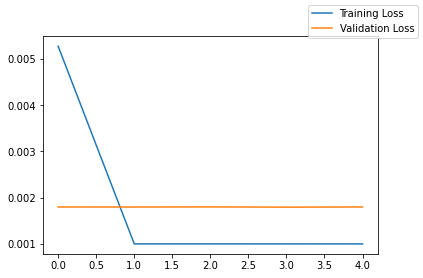

In [15]:
trained_model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [14]:
random.seed(0)
sample = random.sample(list(X_test.index), 10)
# sample = [0,1]



y_test_pred = train.predict(trained_model, X_test.loc[sample], y_test.loc[sample], device="cpu") # get predictions for each train
y_test_pred_df = pd.DataFrame(y_test_pred, columns=y_test.columns)  # put results into a dataframe

print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test.loc[sample], y_test_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test.loc[sample], y_test_pred_df)}')

print("Test - Ground Truth (normalized):")
display(y_test.loc[sample])
# print("Train - Ground Truth (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train.loc[sample].copy(), reverse=True))  # see ground truths
print("Test - Prediction (normalized):")
display(y_test_pred_df)
# print("Train - Prediction (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

    Test set MAE (L1) loss: 0.025222987392791052
    Test set MSE (L2) loss: 0.0014897141209277579
Test - Ground Truth (normalized):


,y_REV_MA_REG
12926687,0.354524
25432729,0.220632
14112040,0.403825
1358430,0.158107
8687804,0.090964
17155532,0.436123
16305027,0.504109
13587334,0.823121
26299916,0.573353
10177486,0.870463


Test - Prediction (normalized):


,y_REV_MA_REG
0,0.363713
1,0.205962
2,0.457060
3,0.152406
4,0.087994
5,0.404785
6,0.504388
7,0.803521
8,0.587878
9,0.971184


In [ ]:
errors = y_test - y_test_pred_df
errors = errors * 360 * 70

In [ ]:
display(errors)
errors.hist(bins=300)